In [9]:
import exif
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.sparse.linalg import lsqr
from copy import copy
import requests
import os
import shutil
import tempfile
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix, hstack, vstack

In [10]:
def download_images(urls, path):
    for idx in range(len(urls)):
        print(urls[idx], end='')
        r = requests.get(urls[idx], stream=True)
        if r.status_code == 200:
            with open(os.path.join(path, f'image{idx:02d}.jpg'), 'bw') as f:
                shutil.copyfileobj(r.raw, f)
                print('...OK')
        else:
            print('...FAIL')

def read_images(file_pattern, scale_percent=100):
    files = glob.glob(file_pattern)

    imgs = []
    t = []

    for file in files:
        tmp_img = cv2.imread(file)
        width = int(tmp_img.shape[1] * scale_percent // 100)
        height = int(tmp_img.shape[0] * scale_percent // 100)
        dim = (width, height)
        imgs.append(cv2.cvtColor(cv2.resize(tmp_img, dim, interpolation=cv2.INTER_AREA), cv2.COLOR_BGR2RGB))
        info = exif.Image(file)
        t.append(info.exposure_time)
    return (height, width), np.array(imgs), t

def get_weights(Z, L):
    return np.interp(Z, [0, (L-1)/2, L-1], [0, 1, 0]).flatten()

In [116]:
images_urls = ['https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/04_HDR/images/lampicka12.jpg?raw=true',
               'https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/04_HDR/images/lampicka13.jpg?raw=true',
               
               
              ]

with tempfile.TemporaryDirectory() as tempdir:
    download_images(images_urls, tempdir)
    dim, Z, t = read_images(os.path.join(tempdir, "*.jpg"), scale_percent=0.3)

sort_index = sorted(range(len(t)), key=lambda k: t[k])
t = [t[k] for k in sort_index]
Z = Z[sort_index]

print(f'Image shape: {dim}')
print(f'Exposure times [s]: {t}')

r = Z[:, :, :, 0].flatten()
g = Z[:, :, :, 1].flatten()
b = Z[:, :, :, 2].flatten()

# Weight vectors
w_r = get_weights(r, 2**8)
w_g = get_weights(g, 2**8)
w_b = get_weights(b, 2**8)

# Indices to time vector and images
t_ind, Z_ind = np.indices((Z.shape[0], Z.shape[1]*Z.shape[2]))
t_ind = t_ind.flatten()
E_ind = Z_ind

https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/04_HDR/images/lampicka12.jpg?raw=true...OK
https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/04_HDR/images/lampicka13.jpg?raw=true...OK
Image shape: (3, 4)
Exposure times [s]: [1.0, 2.0]


In [117]:
def estimate_exposure_time(w, Z, t_ind, Z_ind):
    eps = np.finfo(float).eps
    a_rows_count = (np.max(Z_ind) + 1) * (np.max(t_ind) + 1) + 1
    A = np.zeros((a_rows_count, np.max(Z_ind) + np.max(t_ind) + 2))
    b = np.zeros((a_rows_count))
    Z_ind = Z_ind.flatten()
    r_ind = list(range(A.shape[0]-1))
    A[r_ind, Z_ind.flatten()] = np.sqrt(w)
    A[r_ind, t_ind.flatten() + 1 + np.max(Z_ind)] = np.sqrt(w)
    b[:-1] = np.log(Z + eps) * np.sqrt(w)
    A[-1, np.max(Z_ind) + 1] = 1
    sol = lsqr(A, b)
    return sol[0][np.max(Z_ind) + 1:]

t_est_r = estimate_exposure_time(w_r, r, t_ind, E_ind)
t_est_g = estimate_exposure_time(w_g, g, t_ind, E_ind)
t_est_b = estimate_exposure_time(w_b, b, t_ind, E_ind)
print(np.log(t[0]), t_est_r)

print(f'Exposure time estimation (red): ', np.exp(t_est_r))
print(f'Exposure time estimation (green): ', np.exp(t_est_g))
print(f'Exposure time estimation (blue): ', np.exp(t_est_b))
print(f'Real exposure time: ', t)

0.0 [3.62333590e-16 2.83580206e-01]
Exposure time estimation (red):  [1.         1.32787538]
Exposure time estimation (green):  [1.         1.35486866]
Exposure time estimation (blue):  [1.00000001 1.3957775 ]
Real exposure time:  [1.0, 2.0]


C:\Users\USER\AppData\Local\Temp\ipykernel_16256\2077861989.py:39: RuntimeWarning: overflow encountered in square
  data_fit_term = np.sum(w * diff**2)


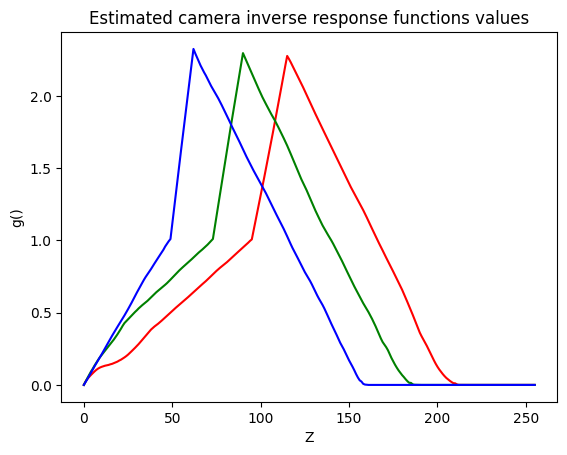

In [118]:
import numpy as np
from scipy.optimize import minimize

def estimate_response_debevec(w, L, Z, t_vec, E_ind, lambd):
    '''
    Estimates camera inverse response function values.

    Parameters:
    w (float): An array of shape (N,) of weights.
    L (int): number of pixel intensity discrete levels
    Z (numpy.ndarray): An array of shape (N,) containing the pixel intensities.
    t_vec (numpy.ndarray): An array of shape (P,) containing the exposure times.
    E_ind (numpy.ndarray): An array of shape (P, N) containing the pixel irradiance values.
    lambd (float): Regularization parameter.

    Returns:
    numpy.ndarray: An array of shape (L,) containing the estimated camera inverse response function values.
    '''
    N = len(Z)
    P = len(t_vec)
    Z_max = np.max(Z)

    # Initialize response function
    g = np.zeros(L)

    # Build the optimization problem
    def objective_function(x):
        # Parameters to optimize: g values for each intensity level
        g_values = x[:L]

        # Regularization term
        reg_term = lambd * np.sum((g_values[1:] - g_values[:-1])**2)

        # Data fitting term
        diff = np.zeros((P, N))
        for i in range(P):
            diff[i, :] = np.exp(g_values[Z[i]] - np.log(t_vec[i])) - E_ind[i, :]

        data_fit_term = np.sum(w * diff**2)

        return data_fit_term + reg_term

    # Initial guess for optimization
    initial_guess = np.zeros(L)

    # Constrain the first and last values of g to be 0
    constraints = ({'type': 'eq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[-1]})

    # Run the optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', constraints=constraints)

    # Extract the optimized g values
    g_optimized = result.x[:L]

    return g_optimized

# Example usage:
lambda_ = 2
g_r_estimated = estimate_response_debevec(w_r, 2**8, r, np.exp(t), np.exp(t_est_r).reshape((len(t), -1)), lambda_)
g_g_estimated = estimate_response_debevec(w_g, 2**8, g, np.exp(t), np.exp(t_est_g).reshape((len(t), -1)), lambda_)
g_b_estimated = estimate_response_debevec(w_b, 2**8, b, np.exp(t), np.exp(t_est_b).reshape((len(t), -1)), lambda_)
plt.plot(g_r_estimated, 'r')
plt.plot(g_g_estimated, 'g')
plt.plot(g_b_estimated, 'b')
plt.title('Estimated camera inverse response functions values');
plt.xlabel('Z')
plt.ylabel('g()');

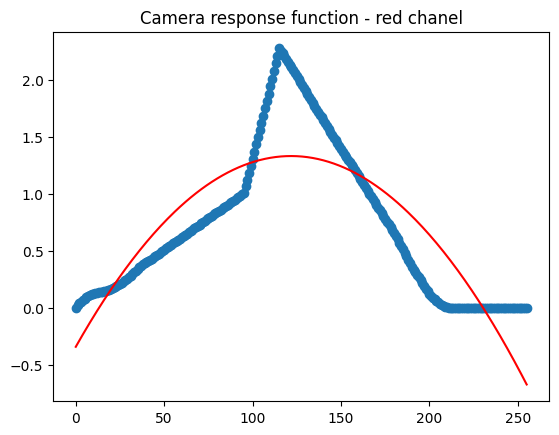

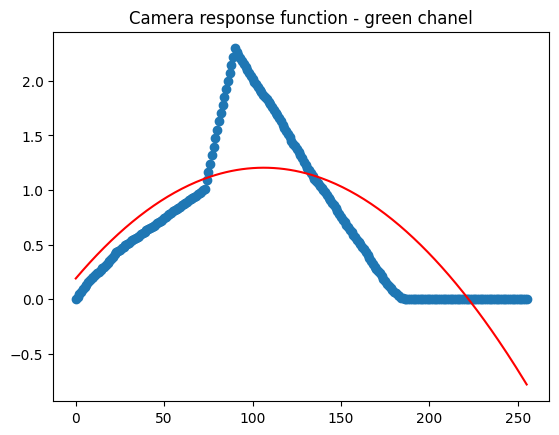

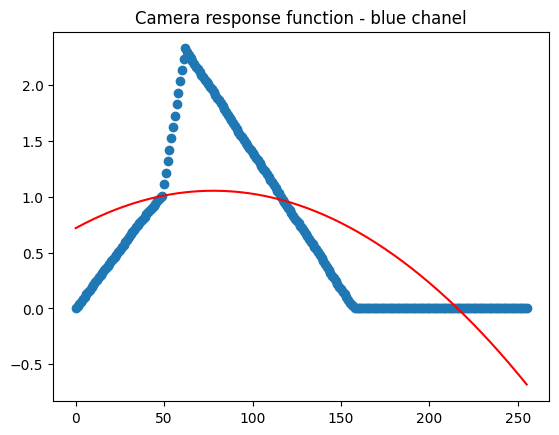

In [119]:
def fit_response(L, g, degree=2):
    g_val = []
    for idx in range(L):
        g_val.append([idx, g[idx]])
    g_val = np.array(g_val)
    
    poly_transform = PolynomialFeatures(degree=degree, include_bias=False).fit(g_val[:,0].reshape((-1,1)))
    poly_trans = lambda x: poly_transform.transform(x.reshape((-1,1)))
    z_poly = poly_trans(g_val[:,0])
    g_model = LinearRegression()
    g_model.fit(z_poly, g_val[:,1])
    g_model_pred = g_model.predict(poly_trans(g_val[:,0]))

    plt.figure()
    plt.scatter(x=g_val[:,0], y=g_val[:,1])
    plt.plot(g_model_pred, 'r')
    
    return g_model_pred

g_model_r = fit_response(2**8, g_r_estimated, degree=2)
plt.title('Camera response function - red chanel')
g_model_g = fit_response(2**8, g_g_estimated, degree=2)
plt.title('Camera response function - green chanel')
g_model_b = fit_response(2**8, g_b_estimated, degree=2)
plt.title('Camera response function - blue chanel');

In [120]:
with tempfile.TemporaryDirectory() as tempdir:
    download_images(images_urls, tempdir)
    dim_f, Z_f, t_f = read_images(os.path.join(tempdir, "*.jpg"), scale_percent = 100)


    



https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/04_HDR/images/lampicka12.jpg?raw=true...OK
https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/04_HDR/images/lampicka13.jpg?raw=true...OK


In [122]:
import numpy as np

def pixel_irradiance(log_exposure, weights, pixel_values):
    weighted_sum = np.sum(weights * (pixel_values - log_exposure))
    total_weight = np.sum(weights)
    irradiance = weighted_sum / total_weight
    return irradiance

def hdr_from_exposure(g, w, Z, t):
    w_img = np.sqrt(w.reshape((len(t), -1)))
    Z_img = np.interp(Z, list(range(2**8)), g).reshape((len(t), -1))
    E = np.zeros(w_img.shape[1], dtype=np.float32)
    t = np.log(t)

    for i in range(w_img.shape[1]):
        E[i] = pixel_irradiance(t, w_img[:, i], Z_img[:, i])

    return E


r_f = Z_f[:, :, :, 0].flatten() 
g_f = Z_f[:, :, :, 1].flatten() 
b_f = Z_f[:, :, :, 2].flatten() 
w_r_f = get_weights(r_f, L) 
w_g_f = get_weights(g_f, L) 
w_b_f = get_weights(b_f, L) 

E_r_est = hdr_from_exposure(g_model_r, w_r_f, r_f, t)
E_g_est = hdr_from_exposure(g_model_g, w_g_f, g_f, t)
E_b_est = hdr_from_exposure(g_model_b, w_b_f, b_f, t)


C:\Users\USER\AppData\Local\Temp\ipykernel_16256\1339605255.py:6: RuntimeWarning: invalid value encountered in scalar divide
  irradiance = weighted_sum / total_weight


C:\Users\USER\AppData\Local\Temp\ipykernel_16256\1266694946.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(E_r_est.reshape(dim_f)))


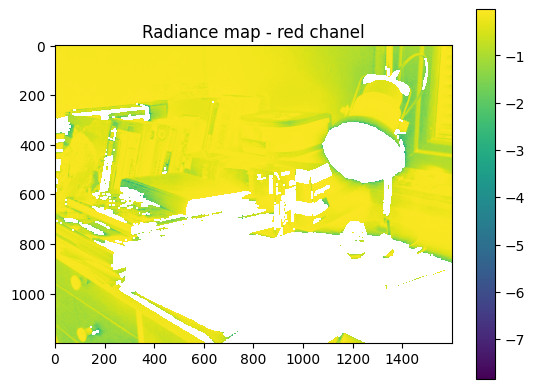

In [123]:
plt.imshow(np.log(E_r_est.reshape(dim_f)))
plt.colorbar()
plt.title('Radiance map - red chanel');

C:\Users\USER\AppData\Local\Temp\ipykernel_16256\2356732562.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(E_g_est.reshape(dim_f)))


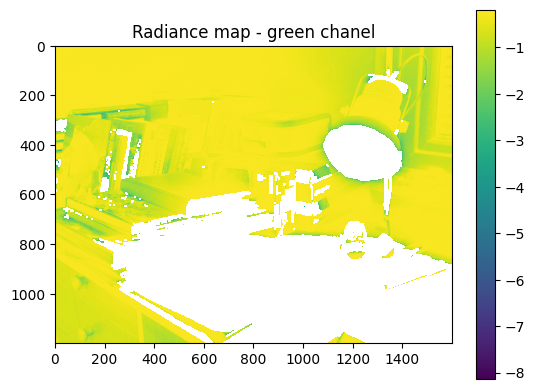

In [124]:
plt.imshow(np.log(E_g_est.reshape(dim_f)))
plt.colorbar()
plt.title('Radiance map - green chanel');

C:\Users\USER\AppData\Local\Temp\ipykernel_16256\658158187.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(E_b_est.reshape(dim_f)))


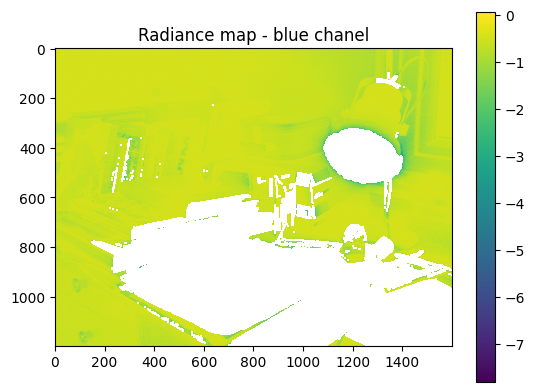

In [125]:
plt.imshow(np.log(E_b_est.reshape(dim_f)))
plt.colorbar()
plt.title('Radiance map - blue chanel');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\USER\OneDrive\Masaüstü\MPIA_HW1\my_venv\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


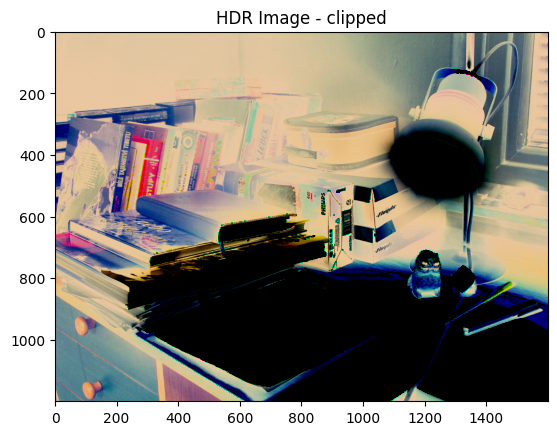

In [126]:
hdr = np.stack((E_r_est.reshape(dim_f), E_g_est.reshape(dim_f), E_b_est.reshape(dim_f)), axis=-1)
plt.imshow(hdr)
plt.title('HDR Image - clipped');

C:\Users\USER\AppData\Local\Temp\ipykernel_16256\232170218.py:3: RuntimeWarning: invalid value encountered in cast
  res_debevec = np.clip(res_debevec*255, 0, 255).astype('uint8')


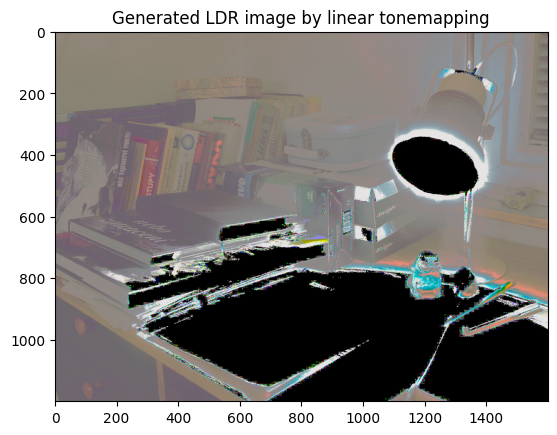

In [114]:
tonemap1 = cv2.createTonemap(gamma=1)
res_debevec = tonemap1.process(np.log(hdr.copy()).astype(np.float32))
res_debevec = np.clip(res_debevec*255, 0, 255).astype('uint8')
plt.imshow(res_debevec)
plt.title('Generated LDR image by linear tonemapping');

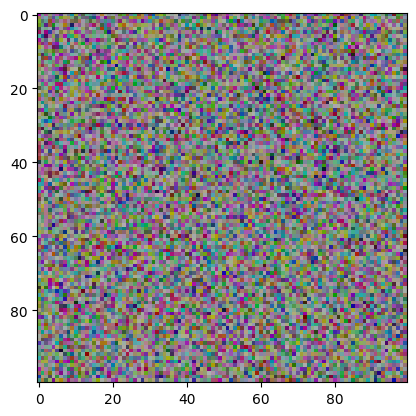

In [127]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hdr_to_ldr_operator(radiance_map, b=0.5, ldmax=100):
    max_radiance = np.max(radiance_map)
    a = ldmax * 0.01 / np.log10(max_radiance + 1)
    c = np.log(b) / np.log(0.5)
    ldr = a * np.log(radiance_map + 1) / (np.log(2 + (radiance_map / max_radiance) ** c * 8))
    return ldr

def log_tonemap(hdr, b=0.5, ldmax=100):
    ldr = np.zeros(hdr.shape)
    for idx in range(hdr.shape[-1]):
        ldr[:, :, idx] = hdr_to_ldr_operator(hdr[:, :, idx], b, ldmax)
    return np.clip(ldr * 255, 0, 255).astype('uint8')


hdr_debevec = np.random.rand(100, 100, 3) 

ldr_debevec = log_tonemap(hdr_debevec, b=0.5, ldmax=70)
plt.imshow(cv2.cvtColor(ldr_debevec, cv2.COLOR_BGR2RGB))
plt.show()

